# Multi-word vector embeddings

Some models can generate embeddings for multi-word phrases:

* Sentence-BERT
* OpenAI: ada-002, text-embedding-3

https://huggingface.co/spaces/mteb/leaderboard

In [37]:
# Load in the vectors from movies.json, {movie: [vector]}
import json
import numpy as np

with open('openai_movies.json') as f:
    movies = json.load(f)

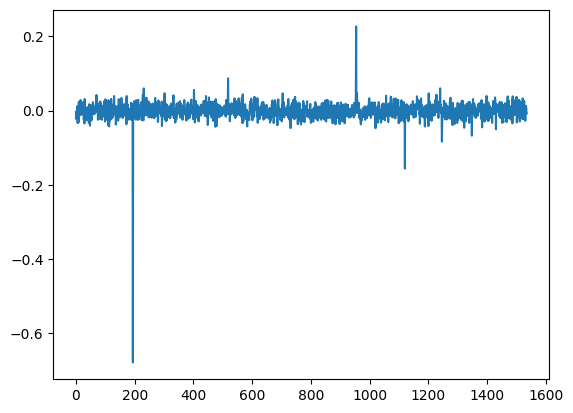

In [38]:
import matplotlib.pyplot as plt
import numpy as np

movie = movies['Moana']
plt.plot(movie)
plt.show()

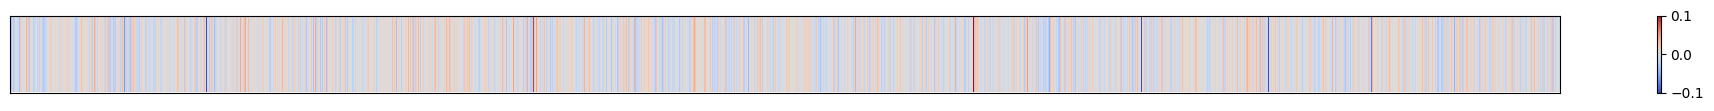

In [39]:
import matplotlib.pyplot as plt

movie = movies['Frozen']

data = np.array(movie).reshape(1, -1)

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(25, 1))

# Display the data as an image, assuming most values between -0.1 and 0.1
cax = ax.imshow(data, cmap='coolwarm', aspect='auto', vmin=-0.1, vmax=0.1)

# Add color bar
cbar = fig.colorbar(cax, orientation='vertical')

# Set ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

[Text(0, 0, 'Frozen'), Text(0, 1, 'Moana'), Text(0, 2, 'Pearl Harbor')]

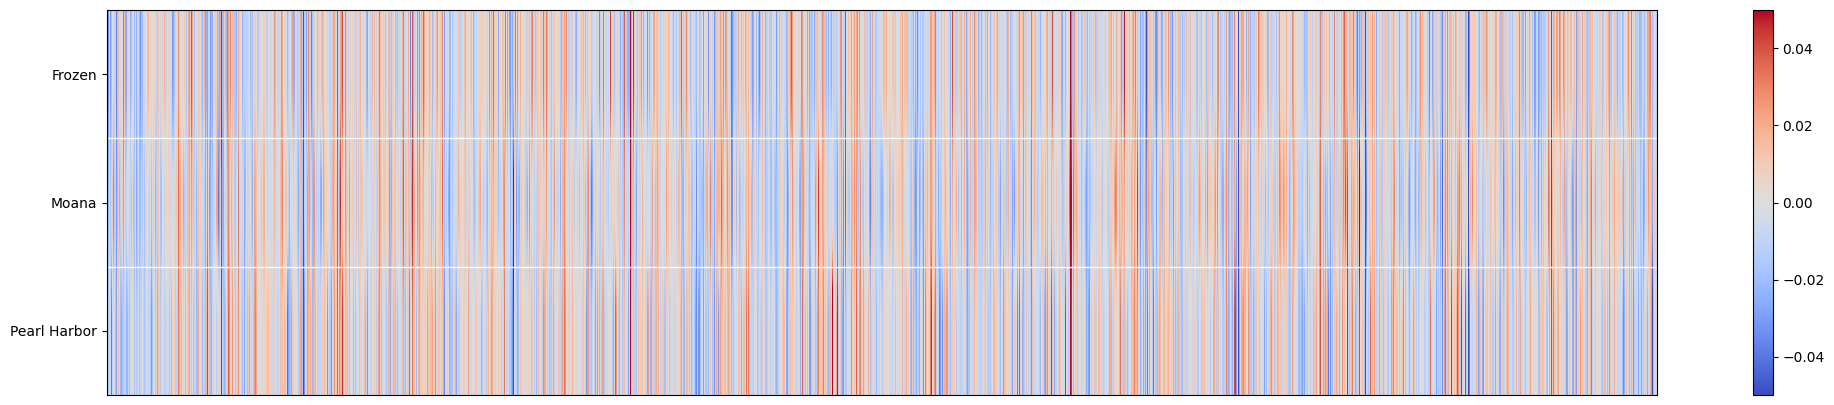

In [40]:
# Now compare the vectors for two movies with similar plots: Frozen and Moana

movie_names = ['Frozen',  'Moana', 'Pearl Harbor']

data = np.array([movies[movie_name] for movie_name in movie_names])

fig, ax = plt.subplots(figsize=(25, 5))

cax = ax.imshow(data, cmap='coolwarm', aspect='auto', vmin=-0.05, vmax=0.05)

# Put lines between the movies
for i in range(1, len(movie_names)):
    ax.axhline(i - 0.5, color='white', lw=1)

# Add color bar
cbar = fig.colorbar(cax, orientation='vertical')

# Set ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticks(range(len(movie_names)))
ax.set_yticklabels(movie_names)

In [41]:
# Are they unit vectors?
print(np.linalg.norm(movies['Frozen']))
print(np.linalg.norm(movies['Moana']))
print(np.linalg.norm(movies['Pearl Harbor']))

1.0000000215763791
0.9999999322056258
1.0000000443636174


## Explore similar movies

In [42]:
# find the 10 most similar movies to Frozen
import numpy as np
import pandas as pd

frozen = movies['The Little Mermaid']

# Calculate the dot product between all other movies
similarities = np.dot(frozen, np.array(list(movies.values())).T)

most_similar = np.argsort(similarities)[::-1][1:11]
similar_movies = [(list(movies.keys())[i], round(similarities[i], 3)) for i in most_similar]

pd.DataFrame(similar_movies, columns=['movie', 'similarity'])


,movie,similarity
0,Moana,0.878
1,The Princess and the Frog,0.876
2,Cinderella,0.875
3,Beauty and the Beast,0.874
4,Sleeping Beauty,0.873
5,Aladdin,0.868
6,Alice in Wonderland,0.857
7,Finding Nemo,0.857
8,Enchanted,0.854
9,Waking Sleeping Beauty,0.854


In [43]:
# Display the 10 least similar movies
least_similar = np.argsort(similarities)[1:11]
similar_movies = [(list(movies.keys())[i], round(similarities[i], 3)) for i in least_similar]

pd.DataFrame(similar_movies, columns=['movie', 'similarity'])

,movie,similarity
0,Un indien dans la ville,0.734
1,Metro,0.737
2,Washington Square,0.738
3,Aspen Extreme,0.745
4,Frank McKlusky C.I.,0.745
5,Terminal Velocity,0.746
6,Powder,0.749
7,In the Army Now,0.749
8,Home on the Range,0.751
9,Running Brave,0.751


In [44]:
# find the two least related movies to each other in the entire dataset

# Calculate the dot product between all movies
similarities = np.dot(np.array(list(movies.values())), np.array(list(movies.values())).T)
np.fill_diagonal(similarities, 1)

# Find the pair of movies with the lowest similarity
least_similar = np.unravel_index(np.argmin(similarities), similarities.shape)
movie_keys = list(movies.keys())
movie_keys[least_similar[0]], movie_keys[least_similar[1]], similarities[least_similar]


('Un indien dans la ville',
 'Hannah Montana/Miley Cyrus: Best of B…',
 0.6841159600603035)

In [45]:
# Find the pair of movies with the highest similarity BUT DO NOT INCLUDE THE SAME MOVIE
np.fill_diagonal(similarities, 0)
most_similar = np.unravel_index(np.argmax(similarities), similarities.shape)
movie_keys[most_similar[0]], movie_keys[most_similar[1]], similarities[most_similar]


('101 Dalmatians', '102 Dalmatians', 0.9700919367215273)

## Search with new embeddings

In [ ]:
import json
import os

from azure.identity import DefaultAzureCredential, get_bearer_token_provider
import openai
import dotenv


dotenv.load_dotenv()

# Set up OpenAI client
AZURE_OPENAI_SERVICE = os.getenv("AZURE_OPENAI_SERVICE")
AZURE_OPENAI_EMBEDDING_DEPLOYMENT = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT")
azure_credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(azure_credential, "https://cognitiveservices.azure.com/.default")
openai_client = openai.AzureOpenAI(
    api_version="2023-07-01-preview",
    azure_endpoint=f"https://{AZURE_OPENAI_SERVICE}.openai.azure.com",
    azure_ad_token_provider=token_provider,
)

def get_embedding(text):
    """Calculate embeddings using OpenAI in a batch (all words at once)"""
    embeddings_response = openai_client.embeddings.create(model=AZURE_OPENAI_EMBEDDING_DEPLOYMENT, input=text)
    return embeddings_response.data[0].embedding

In [50]:
new_vector = get_embedding("peliculas sobre leones")

similarities = np.dot(new_vector, np.array(list(movies.values())).T)

most_similar = np.argsort(similarities)[::-1][1:11]
similar_movies = [(list(movies.keys())[i], round(similarities[i], 3)) for i in most_similar]

pd.DataFrame(similar_movies, columns=['movie', 'similarity'])

,movie,similarity
0,The Tigger Movie,0.831
1,"The Chronicles of Narnia: The Lion, t…",0.820
2,The Jungle Book 2,0.820
3,George Of The Jungle,0.819
4,Tarzan,0.817
5,Jungle 2 Jungle,0.817
6,The Jungle Book,0.814
7,Apocalypto,0.814
8,Cheetah,0.808
9,The Good Dinosaur,0.805
